<a href="https://colab.research.google.com/github/rabi320/Data-Science-Projects/blob/master/English/English_Written_characters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  English Written characters
![](https://www.researchgate.net/profile/Niranjan-S-K/publication/265317661/figure/fig1/AS:306759173459968@1450148494911/Sample-image-of-English-characters.png)

This notebook will be used to classify 3,410 images of handwritten characters in English. This is a classification dataset that can be used for Computer Vision tasks. It contains 62 classes with 55 images of each class. The 62 classes are 0-9, A-Z and a-z.

In [39]:
# extract all files
import zipfile
zp = False
if zp:
    with zipfile.ZipFile("English Handwritten Characters.zip","r") as zip_ref:
        zip_ref.extractall("English Handwritten Characters")

In [40]:
import pandas as pd
df = pd.read_csv("English Handwritten Characters/english.csv")


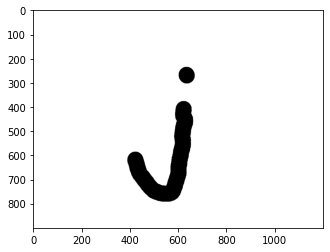

In [41]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as imread
random_image = df.sample()["image"].values[0]# get the image name
img=plt.imread(f"English Handwritten Characters/{random_image}")
plt.imshow(img)
plt.show()

In [42]:
img.shape

(900, 1200, 3)

In [43]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode



In [44]:
class EnglishWrittencharacters(Dataset):
    """English Written characters."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.English_Written_characters = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.English_Written_characters)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.English_Written_characters.iloc[idx, 0])
        image = io.imread(img_name)
        characters = self.English_Written_characters.iloc[idx, 1:]
        characters = np.array([characters])
        characters = characters.astype('float').reshape(-1, 2)
        sample = {'image': image, 'characters': characters}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [45]:
English_dataset = EnglishWrittencharacters(csv_file='English Handwritten Characters/english.csv',
                                    root_dir='English Handwritten Characters',transform = transforms.ToTensor())

f"the data has {English_dataset.__len__()} images"

'the data has 3410 images'

In [46]:
train_size = int(English_dataset.__len__()*0.7)
test_size = int(English_dataset.__len__() - train_size)
trainset, testset = torch.utils.data.random_split(English_dataset, [train_size,test_size])

print(f"train size: {trainset.__len__()}\ntest size: {testset.__len__()}")

train size: 2387
test size: 1023
